In [1]:
import pandas as pd
import numpy as np
import math
from graphviz import Digraph
from IPython.display import Image

## Открываем тренировочные и тестовые данные для алгоритмов ID3 и C4.5

In [2]:
df_train_id3 = pd.read_csv('data/train.csv').drop(['Ticket', 'Cabin', 'Name','Age','Fare','PassengerId'], axis=1)
df_train_id3 = df_train_id3[list(df_train_id3.columns.values[1:])+['Survived']]
df_test_id3 = pd.read_csv('data/test.csv').drop(['Ticket', 'Cabin', 'Name','Age','Fare','PassengerId'], axis=1)

In [3]:
df_train_C4_5 = pd.read_csv('data/train.csv').drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)
df_train_C4_5 = df_train_C4_5[list(df_train_C4_5.columns.values[1:])+['Survived']]
df_test_C4_5 = pd.read_csv('data/test.csv').drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis=1)

In [4]:
y_val = pd.read_csv('data/gender_submission.csv').drop(['PassengerId'], axis=1)
y_val = y_val.values.T[0]
y_val.shape

(418,)

In [5]:
df_train_id3.head()

,Pclass,Sex,SibSp,Parch,Embarked,Survived
0,3,male,1,0,S,0
1,1,female,1,0,C,1
2,3,female,0,0,S,1
3,1,female,1,0,S,1
4,3,male,0,0,S,0


In [6]:
df_train_C4_5.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


# Класс дерева, включающий в себя оба алгоритма

In [7]:
class Tree:
    
    def __init__(self, param = 'id3'):
        self.name = param
        self.branch = None
        self.param = param
        self.rule = None
        self.rule_name = None
        self.branch_ver = None
        self.num = 0
        self.mean = None
        
    def Entropy(self, mas):
        return np.array([-mas[i]/mas.sum()*math.log2(mas[i]/mas.sum()) if mas[i]/mas.sum() != 0 else 0 for i in range(mas.shape[0])]).sum()

    def classes(self, data, list_Keys_val, val_name):
        val = []
        for i in range(list_Keys_val.shape[0]):
            if list_Keys_val[i] in data.groupby(val_name).size():
                val.append(data.groupby(val_name).size()[list_Keys_val[i]])
            else:
                val.append(0)
        return np.array(val)
    
    def Gain(self, data, name, val_name = ''):
        if val_name == '':
            val_name = data.columns.values[-1]
        list_Keys_val = data.groupby(val_name).size().keys()
        data_val = self.classes(data, list_Keys_val, val_name)
        
        Global_Entropy = self.Entropy(data_val)
        if data[name].dtype == np.float64:
            mean_arr = np.sort(data[name].values)
            min_entr = 10000
            abs_mean = 0
            for i in range(mean_arr.shape[0]-1):
                mean = (mean_arr[i] + mean_arr[i+1])/2
                tmp_val = [self.classes(data[data[name]<=mean], list_Keys_val, val_name), 
                           self.classes(data[data[name]>mean], list_Keys_val, val_name)]
                tmp_entr = tmp_val[0].sum()/data_val.sum()*self.Entropy(tmp_val[0])+tmp_val[1].sum()/data_val.sum()*self.Entropy(tmp_val[1])
                if tmp_entr < min_entr:
                    min_entr = tmp_entr
                    abs_mean = mean
            return Global_Entropy - min_entr, abs_mean
        else:
            list_Keys = data.groupby(name).size().keys()
            for i in range(data.groupby(name).size().shape[0]):
                tmp = data[data[name] == list_Keys[i]]
                tmp_val = self.classes(tmp, list_Keys_val, val_name)
                entr_at = self.Entropy(tmp_val)
                Global_Entropy -= tmp_val.sum()/data_val.sum()*entr_at
            return Global_Entropy, None
    
    def fit(self, data):
#         if self.param == 'id3':
            num = self.ID3(data)
            
    def ID3(self, data, num=0):
        if (data.groupby(data.columns.values[-1]).size().shape[0] != 1) and (data.shape[1] != 1):
            map_array = np.array([self.Gain(data, name) for name in data.columns.values[:-1]])
            ind_max = map_array.T[0].argmax()
            favorite_name = data.columns.values[ind_max]
            list_keys_fn = data.groupby(favorite_name).size().keys()
            self.branch = []
            if map_array[ind_max][1] != None:
                self.rule_name = favorite_name + f'\n<={map_array[ind_max][1]}'
                self.param, self.num, self.mean = 'c4.5',num, map_array[ind_max][1]
                mod1 = Tree(self.param)
                mod1.rule = True
                num = mod1.ID3(data[data[favorite_name] <= map_array[ind_max][1]].drop([favorite_name], axis=1), num+1)
                self.branch.append(mod1)
                mod2 = Tree(self.param)
                mod2.rule = False
                num = mod2.ID3(data[data[favorite_name] > map_array[ind_max][1]].drop([favorite_name], axis=1), num+1)
                self.branch.append(mod2)
                return num
            else:
                self.rule_name = favorite_name 
                self.param, self.num ='id3', num
                for key in list_keys_fn:
                    mod = Tree(self.param)
                    mod.rule = key
                    num = mod.ID3(data[data[favorite_name] == key].drop([favorite_name], axis=1), num+1)
                    self.branch.append(mod)
                return num
        else:
            if (data.shape[1] != 1):
                self.num = num
                key = data.groupby(data.columns.values[-1]).size().keys()[0]
                self.branch_ver = 1
                self.branch = key
                return num
            else:
                self.num = num
                list_keys = data.groupby(data.columns.values[-1]).size().keys()
                size = data.groupby(data.columns.values[-1]).size().sum()
                ind_max = np.array([data.groupby(data.columns.values[-1]).size()[key]/size for key in list_keys]).argmax()
                val_max = np.array([data.groupby(data.columns.values[-1]).size()[key]/size for key in list_keys]).max()
                self.branch = list_keys[ind_max]
                self.branch_ver = val_max
                return num
    
    def GetDepth(self, d = 0):
        if type(self.branch) == np.int64:
            return d
        else:
            return np.array([mod.GetDepth(d+1) for mod in self.branch]).max()
    
    def GetVer(self):
        if type(self.branch) == np.int64:
            print({self.branch : self.branch_ver})
        else:
            for mod in self.branch:
                mod.GetVer()
                
                
    def pred(self, data, y_val = ''):
        mas = []
        for i in range(data.shape[0]):
            mas.append(self.future(data.iloc[i]))
        if y_val == '':
            return np.array(mas)
        else:
            return np.array([int(mas[i]==y_val[i]) for i in range(len(mas))]).sum()/len(mas)
    
    def future(self, data):
        if type(self.branch) == np.int64:
            return self.branch
        else:
            tmp = 0
            for mod in self.branch:
                if self.param == 'c4.5':
                    if (data[self.rule_name.split('\n')[0]] <= self.mean) == mod.rule:
                        tmp = mod.future(data)
                        break
                else:
                    if data[self.rule_name]  == mod.rule:
                        tmp = mod.future(data)
                        break
            return tmp
        
    def show(self, flag = True, graph=None, back='', view=False):
        if flag:
            graph = Digraph(name='Graph')
            if self.param == 'id3':
                graph.node(str(self.num), self.rule_name, shape='box', style='filled', fillcolor="blue")
            else:
                graph.node(str(self.num), self.rule_name, shape='box', style='filled', fillcolor="yellow")
        if back == 'rule_name':
            if self.param == 'id3':
                graph.node(str(self.num), self.rule_name, shape='box', style='filled', fillcolor="blue")
            else:
                graph.node(str(self.num), self.rule_name, shape='box', style='filled', fillcolor="yellow")
            return graph
        if back == 'rule':
            if self.rule == None:
                return str(self.branch_ver)
            else:
                return str(self.rule)
        if type(self.branch) == np.int64:
            graph.node(str(self.num), 'val: ' + str(self.branch) + '\n' + 'ver: ' + str(self.branch_ver), shape='ellipse', style='filled', fillcolor="green")
        else:
            for mod in self.branch:
                graph = mod.show(flag=False, graph=graph, back='rule_name')
                graph = mod.show(flag=False, graph=graph, back='rule_name')
                graph.edge(str(self.num), str(mod.num),
                       label=mod.show(flag=False, graph=graph, back='rule'), labelangle='45', labeldistance='2.5')
                graph = mod.show(flag=False, graph=graph)
        if view:
            graph.format = 'png'
            graph.render(f'img/{self.name}_out', view=not view)
            return Image(f'img/{self.name}_out.png')
        else:
            return graph
        
    
        

## Обучаем модель используя алгоритм ID3

In [8]:
model_id3 = Tree(param='id3')
model_id3.fit(df_train_id3)
model_id3.GetDepth() # максимальная глубина

5

### Получаем точность на тестовой выборке

In [9]:
model_id3.pred(df_test_id3, y_val=y_val)

/home/romamart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.8636363636363636

### Выводим визуализацию дерева

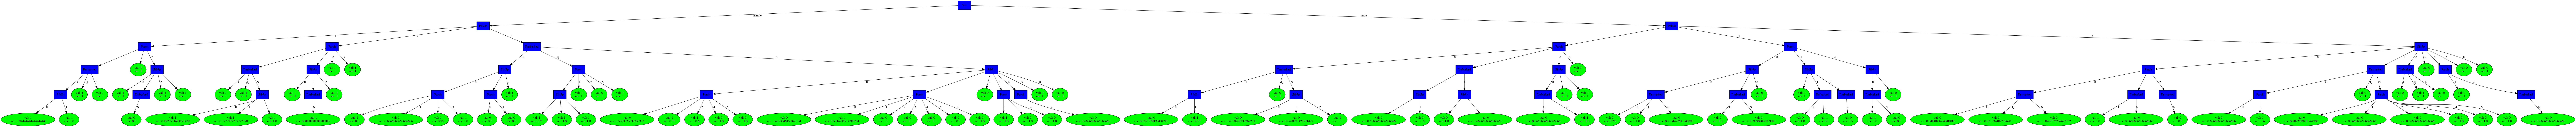

In [10]:
model_id3.show(view=True)

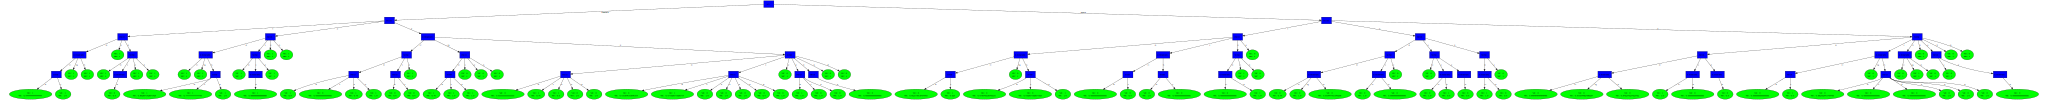

In [11]:
model_id3.show()

## Обучаем модель используя алгоритм ID3

In [12]:
model_C4_5 = Tree(param='c4.5')
model_C4_5.fit(df_train_C4_5)
model_C4_5.GetDepth()

/home/romamart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  


7

### Получаем точность на тестовой выборке

In [13]:
model_C4_5.pred(df_test_C4_5, y_val=y_val)

/home/romamart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.8373205741626795

### Выводим визуализацию дерева

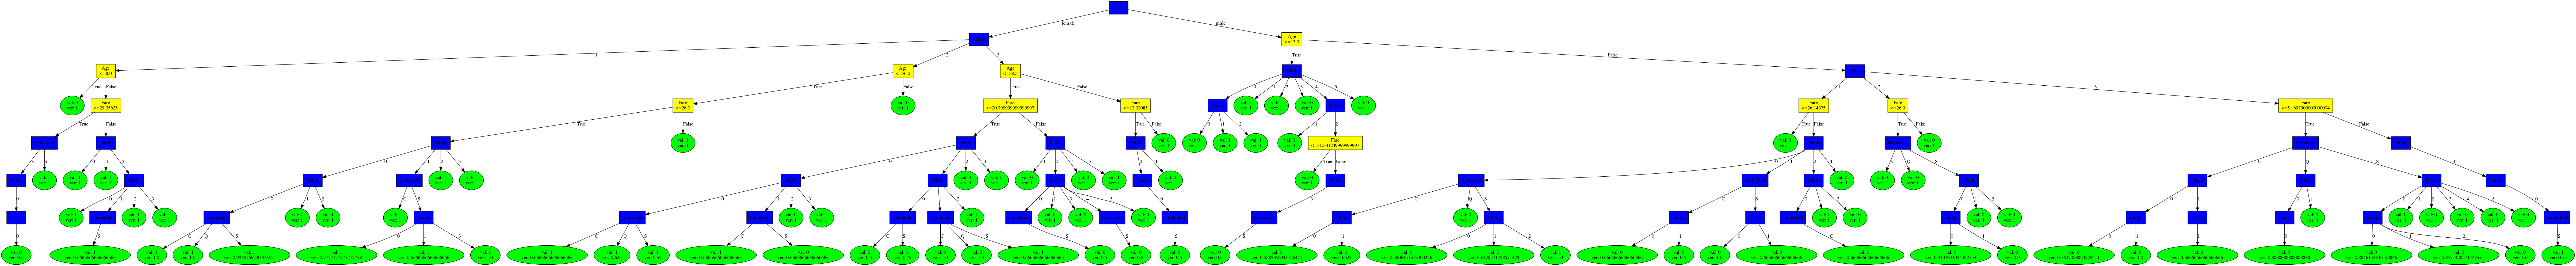

In [14]:
model_C4_5.show(view=True)

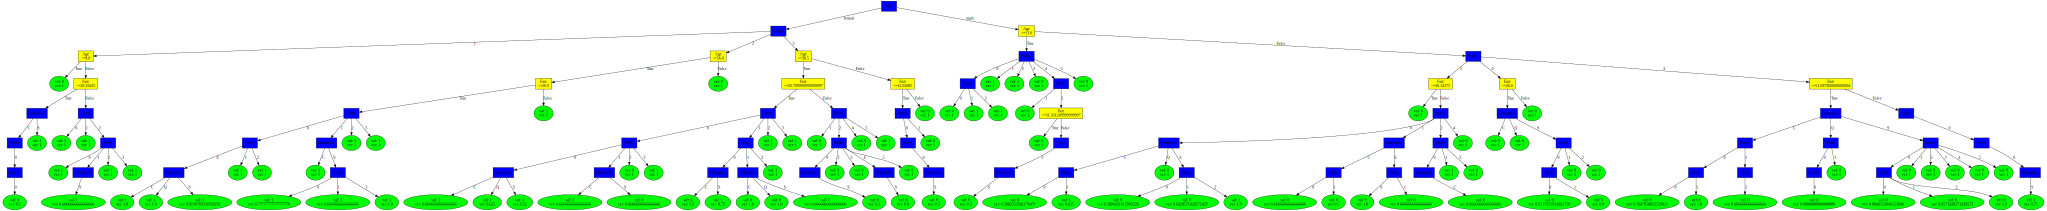

In [15]:
model_C4_5.show()